In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [1]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import Audio, clear_output
import random 
import matplotlib.pyplot as plt
from torchmetrics.functional.classification import multilabel_accuracy,multilabel_f1_score
from sklearn.metrics import f1_score

In [2]:
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch.amp import autocast as autocast
# import torch_xla
# import torch_xla.core.xla_model as xm
from torch.utils.data import DataLoader,Dataset,random_split
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim.lr_scheduler import CosineAnnealingLR,ReduceLROnPlateau

from transformers import ASTFeatureExtractor, ASTModel, ASTConfig, AutoModelForAudioClassification

In [3]:
extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
astmodel = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593",attn_implementation="sdpa")

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
# device=xm.xla_device()

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
random.seed(42)

In [7]:
df = pd.read_csv("/kaggle/input/environmental-sound-classification-50/esc50.csv")
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [8]:
path = "/kaggle/input/environmental-sound-classification-50/audio/audio/"

In [9]:
df2 = df.groupby("target").sample(3)
df3 = df.groupby("target").sample(3)
df4 = df.groupby("target").sample(1)
df1 = df.groupby("target").sample(30)
df5 = df.groupby("target").sample(5)

In [10]:
classes = set(list(range(10,20))+list(range(40,50)))

## Dataset Processing

In [12]:
sr = 16000

In [13]:
def load_audio(file_path, sr=None, duration=None):
    audio, _ = librosa.load(file_path, sr=16000)
    return audio

In [14]:
def mix(z,df):
    
    audio = load_audio(path+df.iloc[z[0]]['filename'])
    a = torch.zeros(50)
    a[df.iloc[z[0]]["target"]] = 1
    
    for j in z[1:]:
        audio += load_audio(path+df.iloc[j]['filename'])
        a[df.iloc[j]["target"]] = 1
        
    return librosa.util.normalize(audio),a

In [15]:
class SoundDS(Dataset):
    
    def __init__(self, df, extractor, data_path, sr, file_list):
        self.df = df
        self.data_path = data_path
        self.sr = sr
        self.file_list = file_list
        self.extractor = extractor
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        y,a = mix(self.file_list[idx],self.df)
        f = self.extractor(y,sampling_rate=self.sr, padding="max_length", return_tensors="pt").input_values[0]
        return f,a

## Model Definition

In [17]:
class MultiAudioClassifier(nn.Module):
    def __init__(self, num_labels=50, lstm_hidden_size=128, num_lstm_layers=4):
        super(MultiAudioClassifier, self).__init__()
        
        self.model = AutoModelForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593",
            attn_implementation="sdpa"
        )
        
        self.pretrained_output_size = 527
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.classifier.parameters():
            param.requires_grad = True
        
        self.lstm = nn.LSTM(
            input_size=self.pretrained_output_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )
    
    def forward(self, features):
        transformer_output = self.model(features).logits
        
        lstm_output, _ = self.lstm(transformer_output.unsqueeze(1))
        
        lstm_last_output = lstm_output.squeeze(1)
        
        output = self.fc(lstm_last_output)
        
        return output

## Training Function

In [18]:
device = "cuda"

In [19]:
def train_epoch(model, train_dl, criterion, optimizer, scaler, device):
    num_labels = 50
    model.train()
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    num_batches = len(train_dl)

    pbar = tqdm(train_dl, desc='Training')
    for step, (x, y) in enumerate(pbar):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        
        with autocast(device_type="cuda",enabled=True):
            p = model(x)
            loss = criterion(p, y)
        
        scaler.scale(loss).backward()
        
        if (step + 1) % 4 == 0:  
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item()
        
        with torch.no_grad():
            train_acc += multilabel_accuracy(p, y, num_labels=num_labels).item()
            train_f1 += f1_score(p.cpu().numpy()>0.0, y.cpu().numpy(), average="weighted",zero_division=0.0).item()

        pbar.set_postfix({'Loss': f'{train_loss/(step+1):.4f}', 
                          'Acc': f'{train_acc/(step+1):.4f}', 
                          'F1': f'{train_f1/(step+1):.4f}'})

    
    return train_loss / num_batches, train_acc / num_batches, train_f1 / num_batches

def validate(model, val_dl, criterion, device, num_labels):
    model.eval()
    val_loss = 0
    val_acc = 0
    val_f1 = 0
    num_batches = len(val_dl)
    
    with torch.no_grad():
        for x, y in tqdm(val_dl, desc='Validation'):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with autocast(device_type="cuda",enabled=True):
                p = model(x)
                loss = criterion(p, y)
            
            val_loss += loss.item()
            val_acc += multilabel_accuracy(p, y, num_labels=num_labels).item()
            val_f1 += f1_score(p.cpu().numpy() > 0.0, y.cpu().numpy(), average="weighted", zero_division=0.0).item()

    return val_loss / num_batches, val_acc / num_batches, val_f1 / num_batches

def train(model, train_dl, criterion, optimizer, num_epochs, device):
    scaler = GradScaler()
    num_labels = 50
    best_val_f1 = 0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss, train_acc, train_f1 = train_epoch(model, train_dl, criterion, optimizer, scaler, device)
        val_loss, val_acc, val_f1 = validate(model, val_dl, criterion, device, num_labels)
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model")

In [20]:
file_list2 = []

In [21]:
for i in range(0, len(df)):
    u = df.iloc[i].name
    if u not in classes:
        file_list2.append(tuple([u]))

In [22]:
for i in tqdm(range(0, len(df3))):
    for j in range(0, len(df2)):
        
        a = df3.iloc[i]["target"]
        b = df2.iloc[j]["target"]
        
        if a != b and (a not in classes and b not in classes):
            file_list2.append((df3.iloc[i].name,df2.iloc[j].name))
    
print(len(file_list2))

100%|██████████| 150/150 [00:03<00:00, 40.97it/s]

9810


In [23]:
for i in tqdm(range(0, len(df4))):
    for j in range(0, len(df4)):
        for k in range(0, len(df4)):
            
            a = df2.iloc[i]["target"]
            b = df3.iloc[j]["target"]
            c = df4.iloc[k]["target"]
            
            if a != b and b != c and c != a and (a not in classes and b not in classes and c not in classes):
                file_list2.append((df2.iloc[i].name,df3.iloc[j].name,df4.iloc[k].name))
            
print(len(file_list2))

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]

32490


In [24]:
l2 = len(file_list2)
random.shuffle(file_list2)

In [25]:
dataset = SoundDS(df,extractor,"/kaggle/input/environmental-sound-classification-50/audio/audio/16000/",16000,file_list2)

In [26]:
num_items = len(dataset)
num_train = round(num_items * 0.97)
num_val = num_items - num_train
train_ds, val_ds = random_split(dataset, [num_train, num_val])

train_dl = DataLoader(train_ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [27]:
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 15.72 GB
Total GPU memory: 15.828 GB


In [28]:
model = MultiAudioClassifier()
model = model.to(device)

In [29]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
train(model, train_dl, criterion, optimizer, num_epochs, device)

Using 2 GPUs
Epoch 1/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.83it/s]


Train Loss: 0.6588, Train Acc: 0.5992, Train F1: 0.1387
Val Loss: 0.5588, Val Acc: 0.8334, Val F1: 0.2654
Saved best model
Epoch 2/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.08it/s]


Train Loss: 0.4571, Train Acc: 0.8781, Train F1: 0.3732
Val Loss: 0.2892, Val Acc: 0.9734, Val F1: 0.8572
Saved best model
Epoch 3/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.95it/s]


Train Loss: 0.2329, Train Acc: 0.9684, Train F1: 0.7807
Val Loss: 0.1482, Val Acc: 0.9772, Val F1: 0.9229
Saved best model
Epoch 4/30


Validation: 100%|██████████| 61/61 [00:16<00:00,  3.71it/s]


Train Loss: 0.1403, Train Acc: 0.9730, Train F1: 0.8577
Val Loss: 0.0997, Val Acc: 0.9774, Val F1: 0.9210
Epoch 5/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.00it/s]


Train Loss: 0.1065, Train Acc: 0.9745, Train F1: 0.8717
Val Loss: 0.0780, Val Acc: 0.9797, Val F1: 0.9306
Saved best model
Epoch 6/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.98it/s]


Train Loss: 0.0882, Train Acc: 0.9766, Train F1: 0.8818
Val Loss: 0.0638, Val Acc: 0.9821, Val F1: 0.9366
Saved best model
Epoch 7/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.04it/s]


Train Loss: 0.0760, Train Acc: 0.9791, Train F1: 0.8902
Val Loss: 0.0535, Val Acc: 0.9852, Val F1: 0.9468
Saved best model
Epoch 8/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.96it/s]


Train Loss: 0.0675, Train Acc: 0.9813, Train F1: 0.8947
Val Loss: 0.0451, Val Acc: 0.9875, Val F1: 0.9485
Saved best model
Epoch 9/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.09it/s]


Train Loss: 0.0608, Train Acc: 0.9830, Train F1: 0.9008
Val Loss: 0.0409, Val Acc: 0.9886, Val F1: 0.9526
Saved best model
Epoch 10/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.00it/s]


Train Loss: 0.0558, Train Acc: 0.9844, Train F1: 0.9056
Val Loss: 0.0372, Val Acc: 0.9898, Val F1: 0.9518
Epoch 11/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]


Train Loss: 0.0523, Train Acc: 0.9853, Train F1: 0.9060
Val Loss: 0.0345, Val Acc: 0.9904, Val F1: 0.9512
Epoch 12/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.07it/s]


Train Loss: 0.0494, Train Acc: 0.9861, Train F1: 0.9087
Val Loss: 0.0312, Val Acc: 0.9917, Val F1: 0.9591
Saved best model
Epoch 13/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.13it/s]


Train Loss: 0.0467, Train Acc: 0.9868, Train F1: 0.9116
Val Loss: 0.0293, Val Acc: 0.9920, Val F1: 0.9571
Epoch 14/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.93it/s]


Train Loss: 0.0448, Train Acc: 0.9872, Train F1: 0.9125
Val Loss: 0.0270, Val Acc: 0.9926, Val F1: 0.9588
Epoch 15/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.06it/s]


Train Loss: 0.0429, Train Acc: 0.9877, Train F1: 0.9148
Val Loss: 0.0251, Val Acc: 0.9927, Val F1: 0.9602
Saved best model
Epoch 16/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.02it/s]


Train Loss: 0.0412, Train Acc: 0.9882, Train F1: 0.9176
Val Loss: 0.0246, Val Acc: 0.9930, Val F1: 0.9587
Epoch 17/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.16it/s]


Train Loss: 0.0400, Train Acc: 0.9884, Train F1: 0.9183
Val Loss: 0.0244, Val Acc: 0.9932, Val F1: 0.9622
Saved best model
Epoch 18/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.10it/s]


Train Loss: 0.0390, Train Acc: 0.9886, Train F1: 0.9179
Val Loss: 0.0239, Val Acc: 0.9933, Val F1: 0.9584
Epoch 19/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.01it/s]


Train Loss: 0.0379, Train Acc: 0.9890, Train F1: 0.9203
Val Loss: 0.0220, Val Acc: 0.9937, Val F1: 0.9624
Saved best model
Epoch 20/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.01it/s]


Train Loss: 0.0369, Train Acc: 0.9893, Train F1: 0.9218
Val Loss: 0.0223, Val Acc: 0.9937, Val F1: 0.9640
Saved best model
Epoch 21/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.03it/s]


Train Loss: 0.0362, Train Acc: 0.9894, Train F1: 0.9222
Val Loss: 0.0215, Val Acc: 0.9938, Val F1: 0.9627
Epoch 22/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.11it/s]


Train Loss: 0.0356, Train Acc: 0.9895, Train F1: 0.9224
Val Loss: 0.0212, Val Acc: 0.9940, Val F1: 0.9643
Saved best model
Epoch 23/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.05it/s]


Train Loss: 0.0348, Train Acc: 0.9897, Train F1: 0.9242
Val Loss: 0.0204, Val Acc: 0.9946, Val F1: 0.9695
Saved best model
Epoch 24/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.97it/s]


Train Loss: 0.0345, Train Acc: 0.9898, Train F1: 0.9236
Val Loss: 0.0208, Val Acc: 0.9942, Val F1: 0.9623
Epoch 25/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.09it/s]


Train Loss: 0.0339, Train Acc: 0.9900, Train F1: 0.9252
Val Loss: 0.0204, Val Acc: 0.9945, Val F1: 0.9671
Epoch 26/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  4.06it/s]


Train Loss: 0.0333, Train Acc: 0.9901, Train F1: 0.9253
Val Loss: 0.0198, Val Acc: 0.9947, Val F1: 0.9664
Epoch 27/30


Validation: 100%|██████████| 61/61 [00:15<00:00,  3.97it/s]


Train Loss: 0.0330, Train Acc: 0.9902, Train F1: 0.9261
Val Loss: 0.0200, Val Acc: 0.9943, Val F1: 0.9639
Epoch 28/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.13it/s]


Train Loss: 0.0325, Train Acc: 0.9903, Train F1: 0.9268
Val Loss: 0.0195, Val Acc: 0.9949, Val F1: 0.9678
Epoch 29/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.09it/s]


Train Loss: 0.0322, Train Acc: 0.9905, Train F1: 0.9275
Val Loss: 0.0198, Val Acc: 0.9944, Val F1: 0.9624
Epoch 30/30


Validation: 100%|██████████| 61/61 [00:14<00:00,  4.21it/s]

Train Loss: 0.0318, Train Acc: 0.9906, Train F1: 0.9284
Val Loss: 0.0190, Val Acc: 0.9946, Val F1: 0.9670


In [80]:
# Epoch 30 - 50
num_epochs = 20
train(model, train_dl, criterion, optimizer, num_epochs, device)

Epoch 1/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.87it/s]


Train Loss: 0.0317, Train Acc: 0.9906, Train F1: 0.9279
Val Loss: 0.0191, Val Acc: 0.9946, Val F1: 0.9659
Saved best model
Epoch 2/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


Train Loss: 0.0313, Train Acc: 0.9906, Train F1: 0.9272
Val Loss: 0.0193, Val Acc: 0.9947, Val F1: 0.9673
Saved best model
Epoch 3/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.90it/s]


Train Loss: 0.0308, Train Acc: 0.9908, Train F1: 0.9289
Val Loss: 0.0187, Val Acc: 0.9951, Val F1: 0.9699
Saved best model
Epoch 4/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.73it/s]


Train Loss: 0.0308, Train Acc: 0.9908, Train F1: 0.9288
Val Loss: 0.0195, Val Acc: 0.9946, Val F1: 0.9656
Epoch 5/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.77it/s]


Train Loss: 0.0304, Train Acc: 0.9909, Train F1: 0.9290
Val Loss: 0.0186, Val Acc: 0.9947, Val F1: 0.9651
Epoch 6/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.92it/s]


Train Loss: 0.0302, Train Acc: 0.9908, Train F1: 0.9285
Val Loss: 0.0185, Val Acc: 0.9949, Val F1: 0.9676
Epoch 7/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


Train Loss: 0.0302, Train Acc: 0.9909, Train F1: 0.9295
Val Loss: 0.0183, Val Acc: 0.9949, Val F1: 0.9686
Epoch 8/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.80it/s]


Train Loss: 0.0297, Train Acc: 0.9910, Train F1: 0.9305
Val Loss: 0.0186, Val Acc: 0.9947, Val F1: 0.9665
Epoch 9/20


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.69it/s]


Train Loss: 0.0295, Train Acc: 0.9911, Train F1: 0.9305
Val Loss: 0.0193, Val Acc: 0.9944, Val F1: 0.9626
Epoch 10/20


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.67it/s]


Train Loss: 0.0293, Train Acc: 0.9910, Train F1: 0.9302
Val Loss: 0.0187, Val Acc: 0.9947, Val F1: 0.9655
Epoch 11/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.72it/s]


Train Loss: 0.0291, Train Acc: 0.9910, Train F1: 0.9293
Val Loss: 0.0185, Val Acc: 0.9949, Val F1: 0.9672
Epoch 12/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.77it/s]


Train Loss: 0.0289, Train Acc: 0.9912, Train F1: 0.9307
Val Loss: 0.0186, Val Acc: 0.9947, Val F1: 0.9651
Epoch 13/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.82it/s]


Train Loss: 0.0286, Train Acc: 0.9913, Train F1: 0.9319
Val Loss: 0.0195, Val Acc: 0.9941, Val F1: 0.9616
Epoch 14/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.77it/s]


Train Loss: 0.0285, Train Acc: 0.9913, Train F1: 0.9309
Val Loss: 0.0182, Val Acc: 0.9950, Val F1: 0.9701
Saved best model
Epoch 15/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.82it/s]


Train Loss: 0.0284, Train Acc: 0.9913, Train F1: 0.9308
Val Loss: 0.0181, Val Acc: 0.9950, Val F1: 0.9683
Epoch 16/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.77it/s]


Train Loss: 0.0282, Train Acc: 0.9915, Train F1: 0.9325
Val Loss: 0.0177, Val Acc: 0.9952, Val F1: 0.9709
Saved best model
Epoch 17/20


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.54it/s]


Train Loss: 0.0279, Train Acc: 0.9915, Train F1: 0.9328
Val Loss: 0.0177, Val Acc: 0.9950, Val F1: 0.9665
Epoch 18/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.88it/s]


Train Loss: 0.0278, Train Acc: 0.9916, Train F1: 0.9336
Val Loss: 0.0175, Val Acc: 0.9950, Val F1: 0.9664
Epoch 19/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.82it/s]


Train Loss: 0.0277, Train Acc: 0.9915, Train F1: 0.9322
Val Loss: 0.0173, Val Acc: 0.9951, Val F1: 0.9682
Epoch 20/20


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.76it/s]

Train Loss: 0.0275, Train Acc: 0.9916, Train F1: 0.9331
Val Loss: 0.0176, Val Acc: 0.9950, Val F1: 0.9687


In [81]:
# Epoch 50 - 60
num_epochs = 10
train(model, train_dl, criterion, optimizer, num_epochs, device)

Epoch 1/10


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.79it/s]


Train Loss: 0.0272, Train Acc: 0.9917, Train F1: 0.9337
Val Loss: 0.0175, Val Acc: 0.9954, Val F1: 0.9715
Saved best model
Epoch 2/10


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.84it/s]


Train Loss: 0.0271, Train Acc: 0.9917, Train F1: 0.9335
Val Loss: 0.0170, Val Acc: 0.9953, Val F1: 0.9704
Epoch 3/10


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.87it/s]


Train Loss: 0.0268, Train Acc: 0.9918, Train F1: 0.9342
Val Loss: 0.0175, Val Acc: 0.9949, Val F1: 0.9657
Epoch 4/10


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


Train Loss: 0.0268, Train Acc: 0.9917, Train F1: 0.9329
Val Loss: 0.0168, Val Acc: 0.9952, Val F1: 0.9695
Epoch 5/10


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.91it/s]


Train Loss: 0.0266, Train Acc: 0.9918, Train F1: 0.9344
Val Loss: 0.0174, Val Acc: 0.9951, Val F1: 0.9669
Epoch 6/10


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.68it/s]


Train Loss: 0.0267, Train Acc: 0.9918, Train F1: 0.9334
Val Loss: 0.0168, Val Acc: 0.9955, Val F1: 0.9710
Epoch 7/10


Validation: 100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


Train Loss: 0.0266, Train Acc: 0.9918, Train F1: 0.9345
Val Loss: 0.0170, Val Acc: 0.9952, Val F1: 0.9687
Epoch 8/10


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.64it/s]


Train Loss: 0.0263, Train Acc: 0.9918, Train F1: 0.9332
Val Loss: 0.0176, Val Acc: 0.9949, Val F1: 0.9666
Epoch 9/10


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.57it/s]


Train Loss: 0.0264, Train Acc: 0.9919, Train F1: 0.9343
Val Loss: 0.0173, Val Acc: 0.9953, Val F1: 0.9703
Epoch 10/10


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.66it/s]

Train Loss: 0.0260, Train Acc: 0.9920, Train F1: 0.9350
Val Loss: 0.0171, Val Acc: 0.9953, Val F1: 0.9701


## Inference

In [82]:
torch.save(model.state_dict(), 'AST_model_4LSTM2.pt')
torch.save(model.state_dict(), 'AST_model_4LSTM2.pth')

In [37]:
def get_sample_cases(n,df,file_list2,s):
    test = []    
    if s == 2:
        for i in range(0, len(df3)):
            for j in range(0, len(df2)):
                a = df3.iloc[i]["target"]
                b = df.iloc[j]["target"]
                if a != b and (a not in classes and b not in classes):
                    x = (df3.iloc[i].name,df.iloc[j].name)
                    if x not in file_list2:
                        test.append(x)
                        if len(test) == n:
                            return test
    if s == 3:
        for i in range(1000,2000):
            for j in range(2000):
                for k in range(2000):
                    a = df.iloc[i]["target"]
                    b = df.iloc[j]["target"]
                    c = df.iloc[k]["target"]

                    if a != b and b != c and c != a and (a not in classes and b not in classes and c not in classes):
                        x = (df.iloc[i].name,df.iloc[j].name,df.iloc[k].name)
                        if x not in file_list2:
                            test.append(x)
                            if len(test) == n:
                                return test

In [56]:
def inference(s):
    y,l = mix(s,df)
    f = extractor(y,sampling_rate=sr)['input_values'][0]
    model.eval()
    h = 0
    with torch.no_grad():
        h = model(torch.Tensor(f).unsqueeze(0).cuda())
    indices = torch.nonzero(l == 1.0).squeeze()
    indices_list = indices.tolist()
    print("Labels: ",indices_list)
    pred_indices = torch.nonzero((h.squeeze() >= 0) == True)
    pred_indices_list = [x[0].item() for x in pred_indices]
    print("Predictions: ",pred_indices_list)
    
    print("F1 score of Predictions: ",f1_score(h.cpu().squeeze().numpy() > 0,l.cpu().squeeze().numpy() > 0,average="weighted"))
    
#     M = {}
#     for i in range(2000):
#         c = df.iloc[i]["target"]
#         M[c] = df.iloc[i]["category"]
#     for i in pred_indices_list:
#         print(M[i])
    n = 1
    for i in s:
        f = df.iloc[i]
        plt.figure(figsize=(10, 3.5))
        plt.plot(load_audio(path+f["filename"]))
        plt.title(f"Sound {n}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()
        n += 1
    plt.figure(figsize=(10, 3.5))
    plt.plot(y)
    plt.title("Overlapped Sound of 3 sources")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(10, 3.5))
    plt.plot(h.squeeze().cpu().numpy())
    plt.title("Logits of the sample output")


In [85]:
def test_eval(model,test_dl):
    model.eval()
    val_loss = 0
    val_acc = 0
    v = 0
    val_F1 = 0

    with torch.no_grad():

        for x,y in tqdm(test_dl):

            x,y = x.to(device, non_blocking=True),y.to(device, non_blocking=True)
            p = model(x)
            val_loss += criterion(p,y)
            val_acc += multilabel_accuracy(p,y, num_labels=50).item()
#             val_F1 += f1_score(p.cpu().squeeze().numpy()>0, y.cpu().squeeze().numpy(), average="weighted")
            val_F1 += multilabel_f1_score(p, y, average="weighted",threshold=0.0,num_labels=50).item()
            v += 1

    print(f'Acc: {val_acc/v:.4f}, F1: {val_F1/v:.4f}')

In [40]:
test3 = get_sample_cases(2000,df,file_list2,3)
test_ds3 = SoundDS(df,extractor,"/kaggle/input/environmental-sound-classification-50/audio/audio/16000/",16000,test3)
test_dl3 = DataLoader(test_ds3, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [41]:
test2 = get_sample_cases(2000,df,file_list2,2)
test_ds2 = SoundDS(df,extractor,"/kaggle/input/environmental-sound-classification-50/audio/audio/16000/",16000,test2)
test_dl2 = DataLoader(test_ds2, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [83]:
test_eval(model,test_dl3)

100%|██████████| 2000/2000 [03:16<00:00, 10.19it/s]

Acc: 0.9636, F1: 0.9683


In [84]:
test_eval(model,test_dl2)

100%|██████████| 2000/2000 [03:21<00:00,  9.93it/s]

Acc: 0.9900, F1: 0.9903


In [ ]:
test_eval(model,test_dl2)

In [86]:
## Train acc revaluated

model.eval()
val_loss = 0
val_acc = 0
v = 0
val_F1 = 0

with torch.no_grad():

    for x,y in test_dlx:

        x,y = x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p = model(x)
        val_loss += criterion(p,y)
        val_acc += multilabel_accuracy(p,y, num_labels=50).item()
        val_F1 += multilabel_f1_score(p, y, average="weighted",threshold=0.0,num_labels=50).item()
        v += 1
        if v == 1000:
            break
            
print(f'Acc: {val_acc/v:.4f}, F1: {val_F1/v:.4f}')

Acc: 0.9963, F1: 1.0000


In [88]:
## Train acc revaluated
test_dl2 = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
model.eval()
val_loss = 0
val_acc = 0
v = 0
val_F1 = 0

with torch.no_grad():

    for x,y in tqdm(test_dlx):

        x,y = x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p = model(x)
        val_loss += criterion(p,y)
        val_acc += multilabel_accuracy(p,y, num_labels=50).item()
        val_F1 += f1_score(p.cpu().squeeze().numpy()>0, y.cpu().squeeze().numpy(), average="weighted")
        v += 1
        if v == 3000:
            break
clear_output()
print(f'Acc: {val_acc/v:.4f}, F1: {val_F1/v:.4f}')

Acc: 0.9964, F1: 0.9968


In [76]:
# (1000, 0, 144),(1000, 0, 1545),(1412, 133),(236, 61)

In [ ]:
# (1000, 0, 144),(1000, 0, 1545),(1500,0,1545),(1412, 133),(236, 61),(236,70),(100,1876)

Labels:  [8, 29]
Predictions:  tensor([ 8, 29], device='cuda:0')
F1 score of Predictions:  1.0


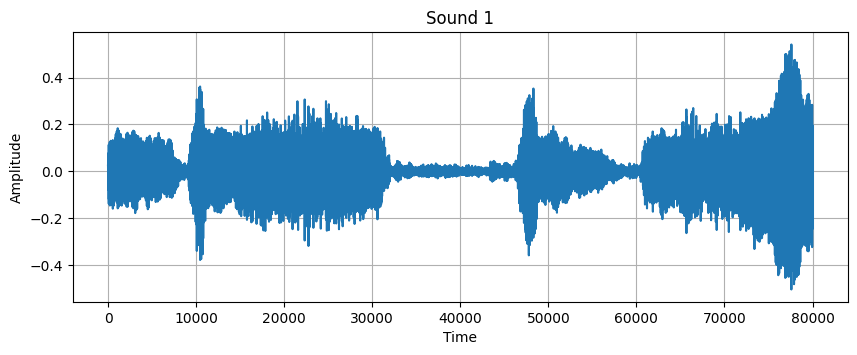

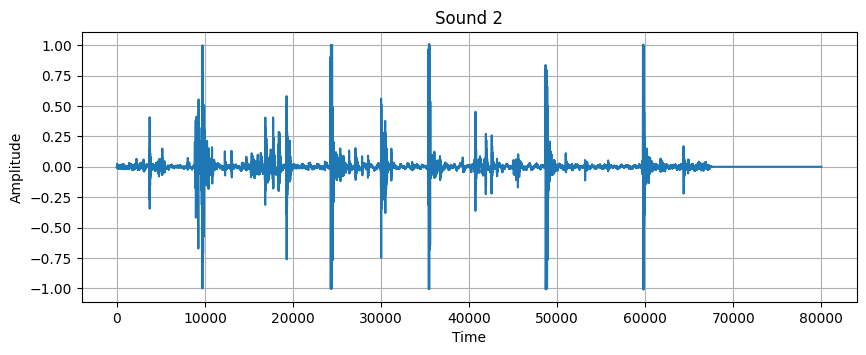

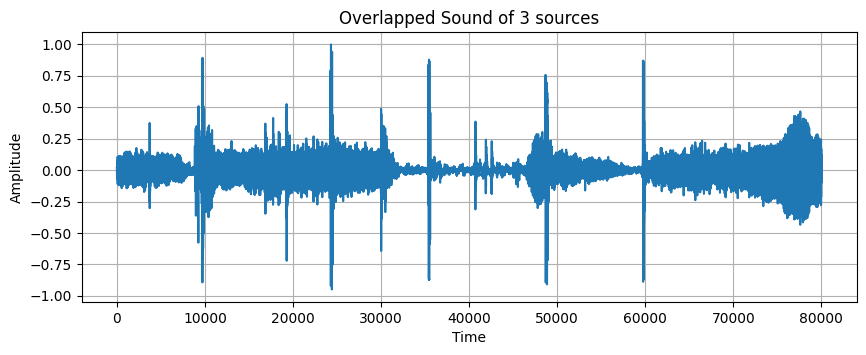

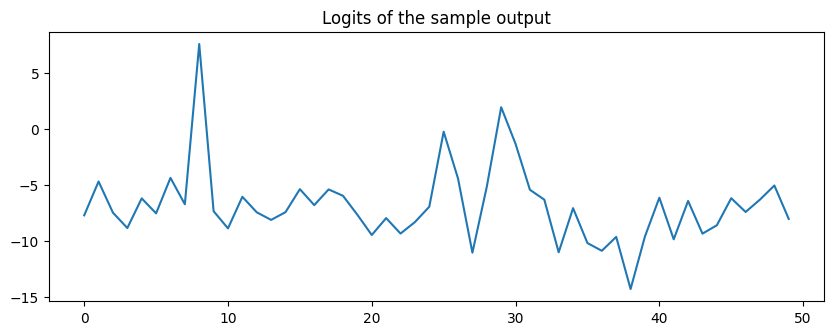

In [74]:
inference(test2[-90])

Labels:  [0, 3, 36]
Predictions:  [0, 3, 36]
F1 score of Predictions:  1.0


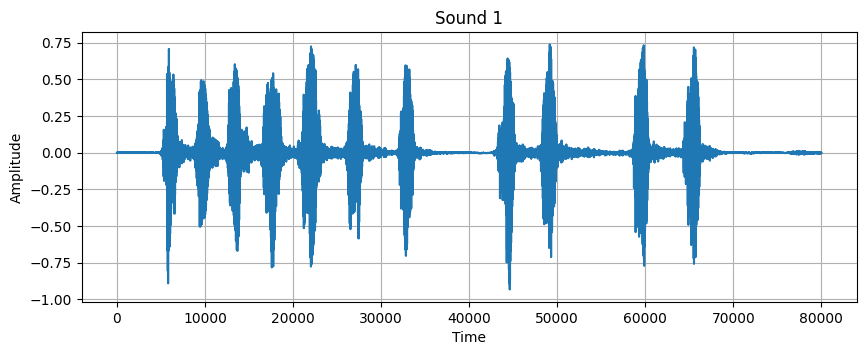

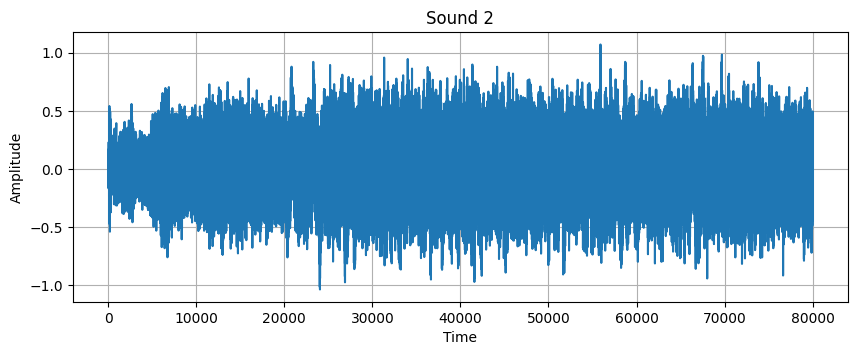

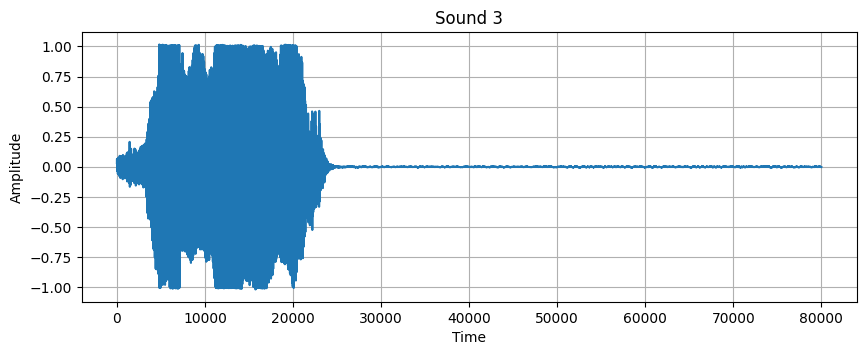

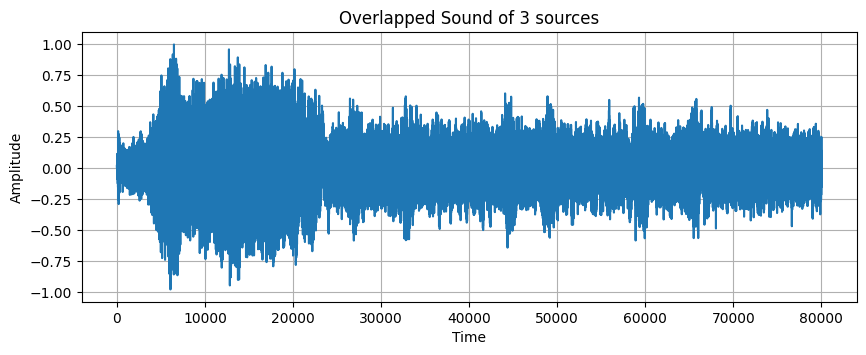

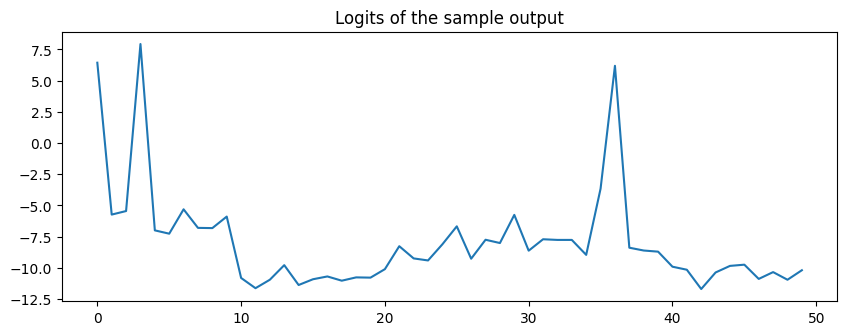

In [44]:
inference((1800, 2, 49))